**Настраиваю тетрадку для работы**

In [89]:
# Импортирую sklearn чтобы перед установкой ядра  была свежая версия библиотеки
#!pip install scikit-learn==1.3.1 -q
import sklearn
# Устанавливаю библиотеки, которых нет
# Устанавливаю ядро 3.7 для корректной работы библиотеки ydata_profiling
#!python -m ipykernel install --user --name py37env --display-name "Python 3.7"
# Устанавливаю версию matplotlib==3.7.3 для корректной работы библиотеки ydata_profiling
#!pip install matplotlib==3.7.3 -q
%matplotlib inline
# Устанавливию библиотеку ydata_profiling
# try:
#     import ydata_profiling
# except ModuleNotFoundError:
#     !pip install ydata_profiling -q
!pip install --upgrade ydata_profiling visions numba -q
# Импортиую нужные для работы библиотеки
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nltk.stem import SnowballStemmer
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, 
    r2_score,
    mean_absolute_error,
)
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    StratifiedKFold,  
    KFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MultiLabelBinarizer
)
import time
from ydata_profiling import ProfileReport
from ydata_profiling.config import Settings
# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)

In [90]:
# Устанавливаю формат отображения для чисел в DataFrame
pd.set_option('display.float_format', '{:,.2f}'.format)
# Устанавливаю тему по умолчанию для диаграмм Seaborn
sns.set_theme(style="ticks")
RANDOM_STATE = 42  

# Разработка модели машинного обучения для предсказания судьбы стартапов

В этом проекте я должен разработать модель машинного обучения, которая поможет определить судьбу стартапа. 



Для достижения этой цели мне предстоит проанализировать псевдо-реальные (реальные данные в которые добавлена синтетическая составляющая) даннын о стартапах, функционировавших в период с 1970 по 2018 годы, построить прогнозную модель для прогоза их закрытия.



Данные о стартапах находятся в файлах: 

- `kaggle_startups_test_28062024.csv`

- `kaggle_startups_train_28062024.csv`

<br><br>



В датасетах содержатся следующие признаки:

- `name` - Название стартапа

- `category_list` - Список категорий, к которым относится стартап

- `funding_total_usd` - Общая сумма финансирования в USD

- `status` - Статус стартапа (закрыт или действующий)

- `country_code` - Код страны

- `state_code` - Код штата

- `region` - Регион

- `city` - Город

- `funding_rounds` - Количество раундов финансирования

- `founded_at` - Дата основания

- `first_funding_at` - Дата первого раунда финансирования

- `last_funding_at` - Дата последнего раунда финансирования

- `closed_at` - Дата закрытия стартапа (если применимо)

- `lifetime` - Время существования стартапа в днях

- `status` - Целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу `operating`, `closed`.

<br><br>



Условия задачи:

- это задача классификации
- нужно потратить время на предобработку и дообогащение данных

## Загрузка и подготовка данных

### Загрузка данных

In [91]:
startups_test = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-39-ds/kaggle_startups_test_28062024.csv')
startups_train = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-39-ds/kaggle_startups_train_28062024.csv')

In [92]:
startups_test.sample(1)

name                     category_list  funding_total_usd  \
12090  ChinaNetCloud  Cloud Computing|IaaS|Web Hosting      10,725,000.00   

      country_code state_code    region      city  funding_rounds  \
12090          CHN         23  Shanghai  Shanghai               8   

      first_funding_at last_funding_at  lifetime  
12090       2009-01-02      2015-08-03      3653

In [93]:
startups_train.sample(1)

name                             category_list  funding_total_usd  \
30277  Salion  Aerospace|Automotive|Enterprise Software       7,000,000.00   

          status country_code state_code region city  funding_rounds  \
30277  operating          NaN        NaN    NaN  NaN               1   

       founded_at first_funding_at last_funding_at closed_at  
30277  1999-11-11       2001-03-05      2001-03-05       NaN

**Вывод по шагу 1.1:**

1. Загружены массивы - `startups_test`,  `startups_train`.

### Предобработка данных

#### Вывожу общую информацию о массивах

In [94]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [95]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


#### Задаю правильные типы столбцов

##### Устанавливаю тип дата и оставляю только месяц и год

In [96]:
# Список названий колонок с датой
date_columns = ['first_funding_at', 'last_funding_at']
# Функция для смены типа на дату и извлечения лет и месяцев
def transform_dates(df, date_columns):
    # Проходим по каждому столбцу с датой
    for col in date_columns:
        # Преобразуем столбец в тип datetime
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Создаем новые столбцы с годом и месяцем
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
    
    # Удаляем исходные столбцы с датами
    df = df.drop(columns=date_columns)
    
    return df

In [97]:
# Применяю функцию к тренировочной выборке
startups_train_transformed = transform_dates(startups_train, date_columns)
# Проверка
startups_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    52515 non-null  object 
 1   category_list           50051 non-null  object 
 2   funding_total_usd       42447 non-null  float64
 3   status                  52516 non-null  object 
 4   country_code            47014 non-null  object 
 5   state_code              45753 non-null  object 
 6   region                  46157 non-null  object 
 7   city                    46157 non-null  object 
 8   funding_rounds          52516 non-null  int64  
 9   founded_at              52516 non-null  object 
 10  closed_at               4917 non-null   object 
 11  first_funding_at_year   52516 non-null  int32  
 12  first_funding_at_month  52516 non-null  int32  
 13  last_funding_at_year    52516 non-null  int32  
 14  last_funding_at_month   52516 non-null

In [98]:
# Применяю функцию к тренировочной выборке
startups_test_transformed = transform_dates(startups_test, date_columns)
# Проверка
startups_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    13125 non-null  object 
 1   category_list           12534 non-null  object 
 2   funding_total_usd       10547 non-null  float64
 3   country_code            11743 non-null  object 
 4   state_code              11430 non-null  object 
 5   region                  11536 non-null  object 
 6   city                    11538 non-null  object 
 7   funding_rounds          13125 non-null  int64  
 8   lifetime                13125 non-null  int64  
 9   first_funding_at_year   13125 non-null  int32  
 10  first_funding_at_month  13125 non-null  int32  
 11  last_funding_at_year    13125 non-null  int32  
 12  last_funding_at_month   13125 non-null  int32  
dtypes: float64(1), int32(4), int64(2), object(6)
memory usage: 1.1+ MB


Все ок

##### Создаю в тренировочной выборке столбец с продолжительностью жизни стартапа

In [99]:
# Функция для расчета жизни стартапа
def calculate_lifetime(df):
    # Преобразуем столбцы с датами в формат datetime
    df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
    df['closed_at'] = pd.to_datetime(df['closed_at'], errors='coerce')

    # Устанавливаем дату по умолчанию, если 'closed_at' пропущен (2018-01-01)
    default_date = pd.to_datetime('2018-01-01')
    
    # Если 'closed_at' пропущен, используем default_date
    df['closed_at'] = df['closed_at'].fillna(default_date)

    # Рассчитываем продолжительность жизни стартапа в днях
    df['lifetime'] = (df['closed_at'] - df['founded_at']).dt.days

    # Удаляем столбец founded_at
    df = df.drop(columns=['founded_at', 'closed_at'])
    
    return df

In [100]:
# Применение функции
startups_train_transformed = calculate_lifetime(startups_train_transformed)

In [101]:
startups_train_transformed.sample(2)

name        category_list  funding_total_usd  \
18414  DIY Auto Repair Shop        Manufacturing                NaN   
10254                 Cisiv  Enterprise Software         640,458.00   

          status country_code state_code         region   city  \
18414  operating          USA         OR  Salem, Oregon  Salem   
10254  operating          GBR         N7            NaN    NaN   

       funding_rounds  first_funding_at_year  first_funding_at_month  \
18414               1                   2014                       1   
10254               4                   2012                       5   

       last_funding_at_year  last_funding_at_month  lifetime  
18414                  2014                      1      1433  
10254                  2015                      5      8401

#### Очистка и приведение к единому виду текстовых значений

In [102]:
# Функция для очистки текста
def clean_text(text):
    if isinstance(text, str):  # Проверка, что это строка
        # Убираем лишние пробелы, приводим к нижнему регистру и удаляем пробелы в начале/конце
        return ' '.join(text.split()).strip().lower()
    return text  # Возвращаем как есть, если это не строка (например, NaN)

In [103]:
# Список текстовых столбцов
text_columns = ['name', 'category_list', 'status', 'country_code', 'state_code', 'region', 'city']
# Функция для для очистки текстовых значений во всех текстовых колонках массива
def df_text_clean(df):
    for column in text_columns:
        if column in df.columns:
            # Применим очистку к каждому элементу в текстовых столбцах
            df[column] = df[column].fillna("unknown").apply(clean_text)

In [104]:
df_text_clean(startups_train)
startups_train.sample(3)

name             category_list  funding_total_usd     status  \
12997     appforge  mobile|services|wireless       8,300,000.00  operating   
32082        globr              social media         479,376.83  operating   
41942  juicycanvas                e-commerce         110,000.00  operating   

      country_code state_code         region      city  funding_rounds  \
12997          usa         ga        atlanta   atlanta               1   
32082          gbr         h9         london    london               2   
41942          usa         ny  new york city  new york               2   

       founded_at first_funding_at last_funding_at closed_at  \
12997  2001-09-23       2003-07-18      2003-07-18       NaN   
32082  2012-01-01       2014-07-10      2015-09-10       NaN   
41942  2012-07-11       2012-12-11      2013-01-01       NaN   

       first_funding_at_year  first_funding_at_month  last_funding_at_year  \
12997                   2003                       7                  2003   
32082                   2014                       7                  2015   
41942                   2012                      12                  2013   

       last_funding_at_month  
12997                      7  
32082                      9  
41942                      1

In [105]:
df_text_clean(startups_test)
startups_test.sample(3)

name                       category_list  \
6627           we cluster                            software   
6389            mycityway  gps|location based services|mobile   
6268  eykona technologies                       biotechnology   

      funding_total_usd country_code state_code         region       city  \
6627          73,300.00          usa         nv      las vegas  henderson   
6389       6,000,000.00          usa         ny  new york city   new york   
6268       1,870,089.00          gbr         k2         london     oxford   

      funding_rounds first_funding_at last_funding_at  lifetime  \
6627               1       2012-08-06      2012-08-06      2557   
6389               2       2010-05-25      2011-02-25      2983   
6268               1       2010-09-24      2010-09-24      3216   

      first_funding_at_year  first_funding_at_month  last_funding_at_year  \
6627                   2012                       8                  2012   
6389                   2010                       5                  2011   
6268                   2010                       9                  2010   

      last_funding_at_month  
6627                      8  
6389                      2  
6268                      9

#### Укрупнение категорий стартапов

In [106]:
def cat_consolidation(original_df, category_mapping):
    # Шаг 0: Создаем копию исходного массива
    df = original_df.copy()    
    
    # Преобразуем его в словарь, где ключом является 'Initial', а значением — 'Final'
    mapping = {row['Initial']: row['Final'] for _, row in category_mapping.iterrows()}
    
    # Шаг 2: Разделить категории по символу |, обработав пропуски
    df['categories_split'] = df['category_list'].fillna('unknown').str.lower().str.split('|')  # Приводим к нижнему регистру
    
    # Шаг 3: Удалить дубликаты категорий для каждого стартапа и применить маппинг
    df['mapped_categories'] = df['categories_split'].apply(
        lambda categories: list(set([mapping.get(cat.strip(), cat) for cat in categories])) if isinstance(categories, list) else []
    )
    
    # Шаг 4: Создать бинарные признаки для категорий
    mlb = MultiLabelBinarizer()
    binary_categories = pd.DataFrame(mlb.fit_transform(df['mapped_categories']), columns=mlb.classes_, index=df.index)
    
    # Шаг 5: Проверяем наличие дубликатов колонок и избегаем их
    columns_to_add = [col for col in binary_categories.columns if col not in df.columns]
    
    # Соединяем бинарные признаки с оригинальными данными
    df = df.join(binary_categories[columns_to_add])
    
    # Шаг 6: Добавляем укрупненные категории, которых не было в исходных данных, с нулями
    all_final_categories = set(mapping.values())
    missing_categories = all_final_categories - set(binary_categories.columns)
    
    # Добавляем пропущенные категории с нулями
    for category in missing_categories:
        df[category] = 0
    
    # Шаг 7: Удаляем ненужные промежуточные столбцы для чистоты
    df = df.drop(columns=['category_list', 'categories_split', 'mapped_categories'])
    
    # Возвращаем изменённый DataFrame
    return df

In [107]:
filepath = '/kaggle/input/categories-rework-claude-new-new/categories_rework_claude_new.xlsx'

In [108]:
category_mapping = pd.read_excel(filepath)

In [109]:
startups_train_cons = cat_consolidation(startups_train, category_mapping)

In [110]:
startups_test_cons = cat_consolidation(startups_test, category_mapping)

In [111]:
startups_train_cons.shape

(52516, 53)

In [112]:
startups_test_cons.shape

(13125, 51)

In [113]:
startups_train_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   name                        52516 non-null  object        
 1   funding_total_usd           42447 non-null  float64       
 2   status                      52516 non-null  object        
 3   country_code                52516 non-null  object        
 4   state_code                  52516 non-null  object        
 5   region                      52516 non-null  object        
 6   city                        52516 non-null  object        
 7   funding_rounds              52516 non-null  int64         
 8   founded_at                  52516 non-null  object        
 9   first_funding_at            52516 non-null  datetime64[ns]
 10  last_funding_at             52516 non-null  datetime64[ns]
 11  closed_at                   4917 non-null   object    

In [114]:
startups_test_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   name                        13125 non-null  object        
 1   funding_total_usd           10547 non-null  float64       
 2   country_code                13125 non-null  object        
 3   state_code                  13125 non-null  object        
 4   region                      13125 non-null  object        
 5   city                        13125 non-null  object        
 6   funding_rounds              13125 non-null  int64         
 7   first_funding_at            13125 non-null  datetime64[ns]
 8   last_funding_at             13125 non-null  datetime64[ns]
 9   lifetime                    13125 non-null  int64         
 10  first_funding_at_year       13125 non-null  int32         
 11  first_funding_at_month      13125 non-null  int32     

In [115]:
startups_train_cons.sample(3)

name  funding_total_usd     status country_code state_code  \
20729   pufetto                NaN  operating      unknown    unknown   
31949   gamevil      80,000,000.00  operating          kor         11   
881    taxsutra         161,000.00  operating          ind         16   

        region     city  funding_rounds  founded_at first_funding_at  ...  \
20729  unknown  unknown               1  2012-01-01       2013-10-01  ...   
31949    seoul    seoul               1  2000-01-01       2013-06-19  ...   
881       pune     pune               1  2010-01-01       2015-02-25  ...   

      Professional Services Real Estate  Recreation  Retail  Social Media  \
20729                     0           0           0       0             0   
31949                     0           0           0       0             0   
881                       0           0           0       0             0   

       Technology  Telecommunications  Transportation  Travel & Hospitality  \
20729           0                   0               0                     0   
31949           0                   0               0                     0   
881             0                   0               0                     0   

       Unknown  
20729        1  
31949        0  
881          0  

[3 rows x 53 columns]

In [116]:
startups_test_cons.sample(3)

name  funding_total_usd country_code state_code       region  \
12474  evinyard          16,773.00          svn         29  svn - other   
4852     deenty         120,000.00          chl         12     santiago   
8659    goonies                NaN      unknown    unknown      unknown   

                 city  funding_rounds first_funding_at last_funding_at  \
12474  gornja radgona               1       2015-09-25      2015-09-25   
4852         santiago               1       2013-01-17      2013-01-17   
8659          unknown               1       2014-10-14      2014-10-14   

       lifetime  ...  Real Estate  Recreation  Retail  Social Media  \
12474      1096  ...            0           0       0             0   
4852       1826  ...            0           0       0             0   
8659       1661  ...            0           0       0             0   

       Technology  Telecommunications  Transportation  Travel & Hospitality  \
12474           0                   0               0                     0   
4852            0                   0               0                     0   
8659            0                   0               0                     0   

       Unknown  Geography  
12474        0          0  
4852         0          0  
8659         1          0  

[3 rows x 51 columns]

Количество категорий уменьшено до 38. Каждая категория теперь бинарный признак.

#### Работаю с дубликатами

In [117]:
def obv_duplicates(data, array_name):
    """
    Создаю функцию, которая проверяет массив на наличие явных дубликатов.
    Parameters:
    data (DataFrame): Входной DataFrame для обработки.
    array_name : Имя массива.
    Returns:
    None
    """
    for col in data.columns:   
        # Проверяю есть ли явные дубликаты строк
        obvious_duplicates_qty = data.duplicated(keep='first').sum()
    if obvious_duplicates_qty != 0:
        print(f"В массиве '{array_name}' количество явных дубликатов строк = {obvious_duplicates_qty}.")
        display(data[data.duplicated()])
    else:
        print(f"Явные дубликаты строк в массиве '{array_name}' отсутствуют.")

In [118]:
# Создаю словарик с массивами и их именами
data= {
    'startups_train_cons':startups_train_cons,
    'startups_test_cons':startups_test_cons
}

In [119]:
# Применяю функцию к массивам
for key, value in data.items():
    obv_duplicates(value, key)

Явные дубликаты строк в массиве 'startups_train_cons' отсутствуют.
Явные дубликаты строк в массиве 'startups_test_cons' отсутствуют.


**Вывод по шагу 1.2:**
1. В массивах `startups_train_cons`, `startups_train_cons` явные дубликаты отсуствуют.

### Исследовательский анализ данных

#### Исследую массивы по отдельности

In [120]:
# Создаю функцию для профилирования данных в массиве с помощью ydata-profiling

def data_profiling(df, report_title, sample_size=None):
    # Если задан sample_size, берём подвыборку данных
    if sample_size and sample_size < len(df):
        df = df.sample(n=sample_size, random_state=42)        
    data_profile=ProfileReport(
        df, 
        duplicates=None, 
        samples=None,
        title=report_title,
        progress_bar = False,
        explorative=True,
        missing_diagrams= None,
        vars={
            "cat":{"lenght": False, "characters": False, "words": True, "histogram_largest":0},
            "num":{"low_categorical_threshold":0}
        },
        correlations={
            "auto": {"calculate": False},
            "pearson": {"calculate": False},
            "spearman": {"calculate": False},
            "kendall": {"calculate": False},
            "phi_k": {"calculate": True, "warn_high_correlations": True},
            "cramers": {"calculate": False},
        },
        plot={
            "missing": {"force_labels": True},
            "scatter_threshold": 5000,
            "cat_freq": {"show": True, "type": "pie", "max_unique": 50}
        },

        interactions={
            "continuous": False
        }   
    )
    return data_profile

In [121]:
# Вывожу отчеты по массивам

reports=[]
for key, value in data.items():
    data_profile = data_profiling(value, key)
    reports.append(data_profile)
    display(data_profile)

#### Сравниваю массивы

In [122]:
def plot_pie_chart_top_10(df, category_columns):
    # Подсчет количества True значений в каждой колонке
    true_counts = df[category_columns].sum()
    # Сортируем категории по количеству значений True и берем топ 10
    top_10 = true_counts.nlargest(10)
    # Построение круговой диаграммы для топ-10 категорий
    plt.figure(figsize=(8, 8))
    plt.pie(
        top_10, 
        labels=top_10.index,  # Метки для категорий
        autopct='%1.1f%%',    # Отображение процентов
        startangle=90,        # Начальный угол диаграммы
        colors=plt.cm.Paired.colors[:10],  # Цвета для секторов
        wedgeprops={'edgecolor': 'black'}  # Границы секторов
    )
    # Добавление заголовка
    plt.title('Top 10 Categories by True Values', size=20)
    plt.show()

In [123]:
category_columns = startups_train_cons.iloc[:,12:].columns

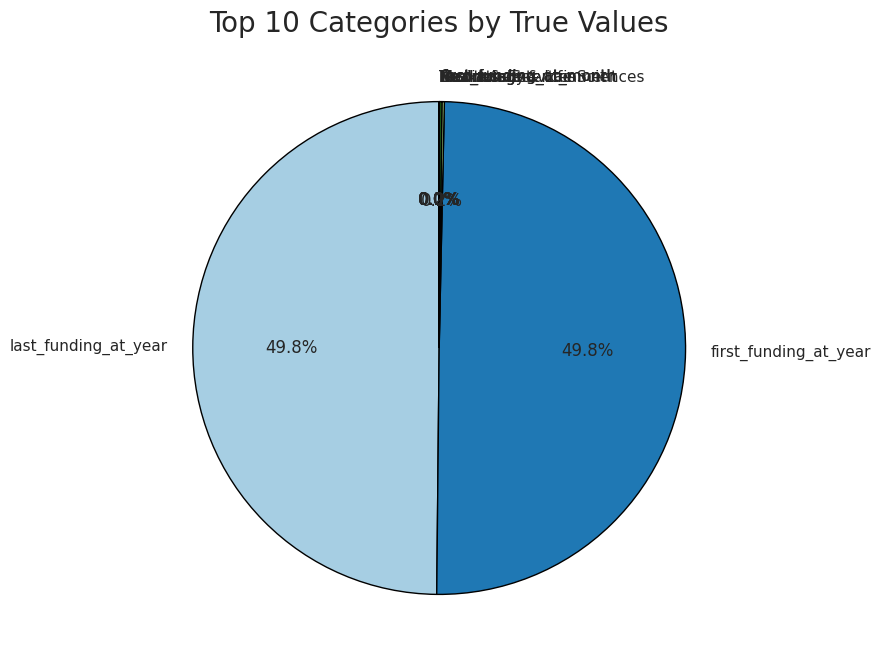

In [124]:
  plot_pie_chart_top_10(startups_train_cons, category_columns)

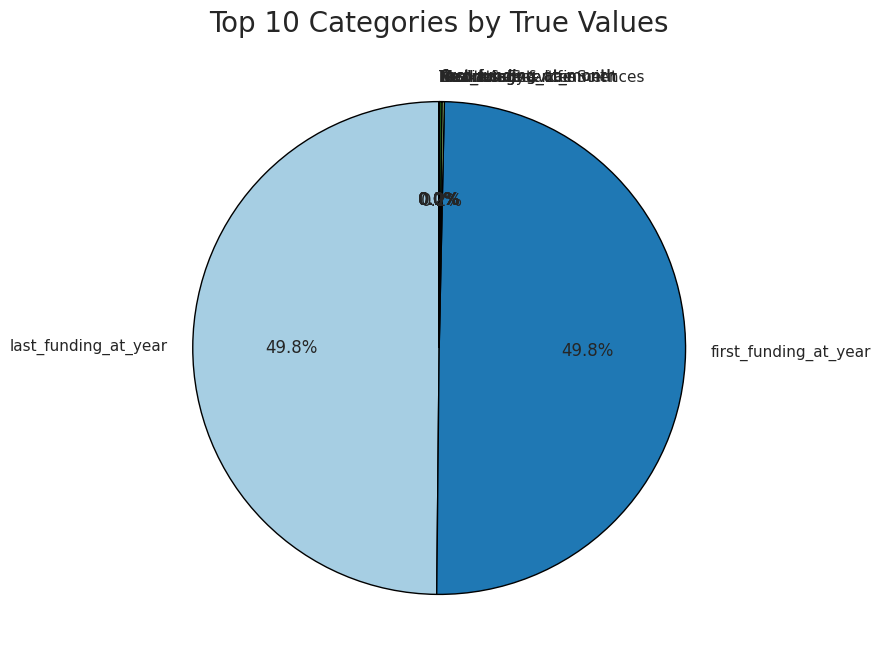

In [125]:
 plot_pie_chart_top_10(startups_test_cons, category_columns)

### Выводы

1. Массив **`geo_data_0`**, признаки:

    - `f0` минимальное значение -1.4, максимум 2.36, медиана 0.5, 95% значений менее 1.94.  Распределение симметричное относительно медианы. Есть 4 пика -1.0(2.9 тыс. скважин), 0.0(3.9 тыс скважин), 1.0(3.9 тыс. скважин), 1.7(3 тыс. скважин). Стандартное отклонение 0.87.

    - `f1` минимальное значение -7.08, максимум 7.85, медиана около 0, 95% значений менее 2.85.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом в нуле (7 тыс.  скважин). Стандартное отклонение 3.73.

    - `f2` минимальное значение -11.97, максимум 16.74, медиана 2.48, 95% значений менее 8.23.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом в медиане (6.5 тыс.  скважин). Стандартное отклонение 3.47.

    - `product` минимальное значение запасов 0, максимум 190 тыс. бареллей, медиана 94.92, 95% значений менее 166 тыс. бареллей.  Распределение симметричное относительно медианы. Имеется 6 пиков - 30 тыс. бареллей(2.4 тыс. скважин), 60 тыс. бареллей (2.9 тыс скважин), 80 тыс бареллей (2.9 тыс. скважин), 110 тыс. бареллей(2.9 тыс. скважин), 130 тыс. бареллей(2.9 тыс скважин), 155 тыс. бареллей(2.4 тыс. скважин). Стандартное отклонение 44.75.

    - **Диаграмма рассеяния (2-3d)** - явно видны два облака точек в координатах f0, f1, f2 закрученные в две спирали с рапределенным по ним значением уровня добычи (с небольшим его ростом с ростом значения f). Очень похоже, что f это трехмерные координаты расположения дна скважины в земле.

    - **Корелляции Пирсона** показали:

        1. Отсутствие высокой корелляции признаков с целевым признаком, только с увеличением f0 немного прирастает добыча

    - **Выводы по подготовке признаков:**

        1. Нужно масштабировать признаки

        2. Можно попробовать регуляризацию (Ridge или Lasso)

        3. В любом случае хорошего результата с применением только линейной регрессии ждать не приходится,  так как только один из трех признаков имееет пусть и слабую, но линейную взаимосвязь с целевым признаком.



2. Признаки массива **`geo_data_1`** имеют схожую картину как и у массива `geo_data_0`.

    - `f0` минимальное значение -31.6, максимум 29.4, медиана 1.14, 95% значений менее 15.  Распределение симметричное относительно медианы. Есть 2 пика -7 (5 тыс. скважин), 8(5 тыс скважин). Стандартное отклонение 8.96.

    - `f1` минимальное значение -26.36, максимум 18.73, медиана -4.81, 95% значений менее 3.67.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (7.5 тыс.  скважин). Стандартное отклонение 5.12.

    - `f2` минимальное значение -0.02, максимум 5.02, медиана 2.01, 95% значений менее 5.  Распределение имеет столбчатый вид со значениями группирующимися вокруг 0,1,2,3,4,5 (каждое примерно по 15 тыс. скважин). Стандартное отклонение 1.7.

    - `product` минимальное значение запасов 0, максимум 138 тыс. бареллей, медиана 68.82, 95% значений менее 138 тыс. бареллей.  Распределение имеет столбчатый вид со значениями группирующимися вокруг 0, 3.18, 26.95, 30.13, 53.91, 57.09, 80.86, 84.04, 111, 135 (каждое примерно по 8.3 тыс. скважин), шаг 3.18 кроме последних двух. Стандартное отклонение 1.7.

    - **Диаграмма рассеяния (2-3d)** - явно 6 наборов точек в координатах f0, f1, f2 ввиде поских блинов по оси f2 c единым значением уровня добычи (с его ростом с ростом значения f2). Очень похоже, что f это трехмерные координаты расположения дна скважины в земле.

    - **Корелляции Пирсона** показали:

        1.Высокую корелляции f2 с целевым признаком (0,99)

    - **Выводы по подготовке признаков:**

        1. Нужно масштабировать признаки

        2. Можно попробовать регуляризацию (Ridge или Lasso)

        3. Можно оставить только признак f2, остальные не будут никак влиять на результат.

 

3. Признаки массива **`geo_data_2`** имеют схожую картину как и у массива `geo_data_0`, `geo_data_1`.

    - `f0` минимальное значение -8.76, максимум 7.24, медиана 0.0009, 95% значений менее 2.85.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (7 тыс.  скважин). Стандартное отклонение 1.73.

    - `f1` минимальное значение -7.08, максимум 7.85, медиана 0.0097, 95% значений менее 2.85.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (7 тыс.  скважин). Стандартное отклонение 1.73. 

    - `f2` минимальное значение -11.97, максимум 16.74, медиана 2.48, 95% значений менее 8.23.  Распределение симметричное относительно медианы, близкое к нормальному с маскимумом медиане (6 тыс.  скважин). Стандартное отклонение 1.47.

    - `product` минимальное значение запасов 0, максимум 190 тыс. бареллей, медиана 94.92, 95% значений менее 166 тыс. бареллей.  Распределение симметричное относительно медианы. Имеется 6 пиков - 30 тыс. бареллей(2.4 тыс. скважин), 60 тыс. бареллей (2.9 тыс скважин), 80 тыс бареллей (2.9 тыс. скважин), 110 тыс. бареллей(2.9 тыс. скважин), 130 тыс. бареллей(2.9 тыс скважин), 155 тыс. бареллей(2.4 тыс. скважин). Стандартное отклонение 44.75.

    - **Диаграмма рассеяния (2-3d)** - эллипс вытянуты вдоль оси f0, в координатах f0, f1, f2 (с ростом уровня добычи с ростом значения f2). Очень похоже, что f это трехмерные координаты расположения дна скважины в земле.

    - **Корелляции Пирсона** показали:

        1.Отсутствие высокой корелляции признаков с целевым признаком, только с увеличением f2 немного прирастает добыча

    - **Выводы по подготовке признаков:**

        1. Нужно масштабировать признаки

        2. Можно попробовать регуляризацию (Ridge или Lasso)

        3. В любом случае хорошего результата с применением только линейной регрессии ждать не приходится,  так как только один из трех признаков имееет пусть и слабую, но линейную взаимосвязь с целевым признаком.

        

4. Скорее всего перед нами результаты разных принципов разведки месторождения:

    1. **0й регион** - скважины формируют две спирали, закрученные друг вокруг друга и измеряется фактическое содержание нефти на дне каждой скважины

    2. **1й регион** - в 6 горизонтах по всем скважинам измеряется некий константный уровень добычи с определенным шагом

    3. **2й регион** - скважины формируют эллипс, и измеряется фактическое содержание нефти на дне каждой скважины

    4. Можно предположить, что **f2 это глубина скважины**, измеряемя относительно какого-то горизонта или уровня моря. Причем положительные значения напревлены в сторону увеличения глубины.

## Обучение и проверка модели

### Подготовка данных

In [42]:
# Выбираю лучшую модель с использованием функций + измеряю потраченное для этого время
X_train=startups_train_cons.drop(columns=['status'])
y_train=startups_train_cons['status']

In [46]:
# Создаю список числовых колонок
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features

['funding_total_usd',
 'funding_rounds',
 'Adult',
 'Agriculture & Food',
 'Arts & Culture',
 'Business Models',
 'Business Services',
 'Construction',
 'Consumer Goods',
 'Demographics',
 'E-commerce',
 'Education',
 'Energy & Utilities',
 'Entertainment',
 'Environmental Services',
 'Events',
 'Finance',
 'Food & Beverage',
 'Geography',
 'Government',
 'Health & Wellness',
 'Healthcare & Life Sciences',
 'Human Resources',
 'Industrial',
 'Legal',
 'Manufacturing',
 'Marketing',
 'Media & Entertainment',
 'Non-Profit',
 'Professional Services',
 'Real Estate',
 'Recreation',
 'Retail',
 'Social Media',
 'Technology',
 'Telecommunications',
 'Transportation',
 'Travel & Hospitality',
 'Unknown']

In [ ]:
# Создаю список категориальных колонок
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features

In [51]:
# Создание пайплайна для OHE признаков
ohe_pipe = Pipeline([
    ('imputation', imputation_pipe),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

ord_pipe = Pipeline([
    ('imputation', imputation_pipe),
    ('ord', OrdinalEncoder(
        categories=[ordinal_columns_info[col] for col in ordinal_features], 
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    )),
    ('imputer_after_ord', SimpleImputer(missing_values=-1, strategy='most_frequent'))
])

# Создание пайплайна для числовых признаков
numeric_pipe = Pipeline([
    ('imputer_nan', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
])


# Создание общего пайплайна для подготовки данных для моделей с OHE
data_preprocessor_ohe = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('ohe', ohe_pipe, categorical_features + ordinal_features)
], remainder='passthrough')

# Создание общего пайплайна для подготовки данных для моделей с OE
data_preprocessor_ord = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', ohe_pipe, categorical_features),
    ('ord', ord_pipe, ordinal_features)
], remainder='passthrough')

NameError: name 'imputation_pipe' is not defined

### Обучение моделей

#### Готовлю пайплайн

In [50]:
# Создание пайплайнов моделей классификации
param_distributions_lr = [
    {
        'preprocessor': [data_preprocessor_ohe],
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10],
        'feature_selection__k': list(range(5, len(X_train.columns) + 1))
    }
]
    

param_distributions_knnc = [   
    {
        'preprocessor': [data_preprocessor_ohe],
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [2, 4],
        'feature_selection__k': list(range(5, len(X_train.columns) + 1))
    }
]

param_distributions_treec = [ 
    {
        'preprocessor': [data_preprocessor_ohe],
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [10, 20, 30],
        'feature_selection__k': list(range(5, len(X_train.columns) + 1))
    }
]

param_distributions_svc = [
    {
        'preprocessor': [data_preprocessor_ohe],
        'model': [SVC(probability=True, random_state=RANDOM_STATE)],
        'model__kernel': ['linear', 'poly', 'rbf'],
        'model__C': [0.1, 1, 10],
        'feature_selection__k': list(range(5, len(X_train.columns) + 1))
    }
]

NameError: name 'data_preprocessor_ohe' is not defined

***Выводы:***

1. Диаграмма рассеяния остатков имеет форму ромба - модель недостаточно хорошо описывает нелинейные зависимости между признаками и целевым признаком.. 

2. Остатки распределены симметрично и нормально. Смещения почти нет. Это хорошо.

3. Модель имеет низкую предсказательную способность - объясняет только 28% процентов целевого признака.

## Общие выводы

1. Проанализированы массивы из трех регионов (`geo_data_0`, `geo_data_1`, `geo_data_2`), которые содержат данные для 100 тысяч скважин каждый, 4 колонки.

2. В массивах явно есть нелинеиные зависимости между признаками и по отношению к целевому признаку. Тулько у массива `geo_data_1` есть высокая корелляция признака f2 с целевым признаком (0,99).

3. Скорее всего перед нами результаты разных принципов разведки месторождения:

   - 0й регион - скважины формируют две спирали, закрученные друг вокруг друга и измеряется фактическое содержание нефти на дне каждой скважины

   - 1й регион - в 6 горизонтах по всем скважинам измеряется некий константный уровень добычи с определенным шагом

   - 2й регион - скважины формируют эллипс, и измеряется фактическое содержание нефти на дне каждой скважины

   - Можно предположить, что f2 это глубина скважины, измеряемя относительно какого-то горизонта или уровня моря. Причем положительные значения напревлены в сторону увеличения глубины.

4. Хороших результатов с помощью линейной регрессии получить не удалось - из-за нелинейной кореляции признаков нулевого и первого региона и слишком сильной кореляции с целевым признаком одного признака и отсутствием ее для остальных признаков в данных региона №1.

5. Достаточный объём сырья для безубыточной разработки одной скважины: 111.11 тыс. баррелей. Средний запас сырья у всех регионов ниже объема, необходимого для безубыточной разработки одной скважины.

6. Рекомендуется выбрать регион для разработки:

In [ ]:
best_region

7. Доверительный интервал указывает, что в 95% случаев средняя прибыль для региона 1 будет находиться в диапазоне от 67,299,569.59 до 821,082,242.58 рублей. Это означает, что в худшем случае прибыль составит чуть более 67 млн рублей, а в лучшем — чуть более 821 млн рублей. Это достаточно широкий интервал и связано это в первую очередь с нелинейными взаимосвязями в данных и органичением в выборе только линейной регрессии для модели прогноза уровня добычи.